# Urban Flood Vulnerability Assessment - Colombo District, Sri Lanka

**Assignment 2 - Scientific Programming for Geospatial Sciences**

**Authors:** Surya Jamuna Rani Subramaniyan (S3664414) & Sachin Ravi (S3563545)

---

## Contents

0. **Setup & Data Download** - Automated data acquisition
1. **Data Loading** - Load real datasets (DEM, CHIRPS, Buildings)
2. **NumPy Array Operations** - Raster processing
3. **PyTorch Tensor Operations** - GPU-aware processing with performance comparison
4. **Vector Processing** - GeoPandas/Shapely operations (3+)
5. **Xarray Data Cubes** - Multi-temporal analysis
6. **Raster-Vector Integration** - Bidirectional operations
7. **Visualization** - Maps and dashboard

---

**Study Area:** Colombo District, Sri Lanka  
**Bounding Box:** 79.82E - 80.22E, 6.75N - 7.05N

## 0. Setup & Data Download

Run this section once to download all required datasets automatically.  
**No API keys required!**

In [1]:
# Core imports
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import torch
import matplotlib.pyplot as plt
import requests
import json
import gzip
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Our modules
import sys
sys.path.append('..')
from src import data_loading, raster_analysis, tensor_operations, vector_analysis, integration, visualization

print("All imports successful!")

All imports successful!


In [2]:
# Study area configuration
COLOMBO_BBOX = {
    'west': 79.82,
    'east': 80.22,
    'south': 6.75,
    'north': 7.05
}

# Paths
DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = Path('../outputs')

# Create directories
for d in [RAW_DIR / 'chirps', RAW_DIR / 'dem', RAW_DIR / 'admin', 
          RAW_DIR / 'buildings', PROCESSED_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Directories ready")

Directories ready


In [3]:
# Helper function for downloads
def download_file(url, output_path, timeout=120):
    """Download a file with progress indication."""
    if output_path.exists():
        print(f"  Already exists: {output_path.name}")
        return True
    
    try:
        print(f"  Downloading: {output_path.name}...")
        response = requests.get(url, stream=True, timeout=timeout)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        downloaded = 0
        
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    pct = (downloaded / total_size) * 100
                    print(f"\r  Downloading: {output_path.name}... {pct:.1f}%", end='', flush=True)
        
        print(f"\n  Saved: {output_path.name}")
        return True
    except Exception as e:
        print(f"  Error: {e}")
        return False

### 0.1 Download SRTM DEM from AWS

In [4]:
# Download SRTM tiles from AWS Open Data
print("Downloading SRTM DEM from AWS...")

# Get required tiles for Colombo
srtm_tiles = ['N06E079', 'N06E080', 'N07E079', 'N07E080']
base_url = "https://elevation-tiles-prod.s3.amazonaws.com/skadi"

dem_files = []
for tile in srtm_tiles:
    lat_dir = tile[:3]
    filename = f"{tile}.hgt.gz"
    url = f"{base_url}/{lat_dir}/{filename}"
    output_path = RAW_DIR / 'dem' / filename
    
    if download_file(url, output_path, timeout=120):
        dem_files.append(output_path)

print(f"\nDownloaded {len(dem_files)} DEM tiles")

  Already exists: N06E079.hgt.gz
  Already exists: N06E080.hgt.gz
  Already exists: N07E079.hgt.gz
  Already exists: N07E080.hgt.gz

Downloaded 4 DEM tiles


### 0.2 Download CHIRPS 2025 Monthly Rainfall Data

In [5]:
# Download CHIRPS 2025 monthly rainfall data (~40 MB)
print("Downloading CHIRPS 2025 monthly rainfall data...")

chirps_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/byYear/chirps-v2.0.2025.monthly.nc"
chirps_path = RAW_DIR / 'chirps' / 'chirps-v2.0.2025.monthly.nc'

download_file(chirps_url, chirps_path, timeout=300)

  Already exists: chirps-v2.0.2025.monthly.nc


True

In [6]:
# Download Colombo District boundary using Nominatim (returns standard GeoJSON)
print("Downloading admin boundaries from Nominatim...")

admin_path = RAW_DIR / 'admin' / 'colombo_boundary.json'

# Delete existing file if it might be the wrong format (Overpass JSON)
if admin_path.exists():
    # We'll check if it's valid GeoJSON by trying to read it, or just overwrite to be safe given the error history
    try:
        gpd.read_file(admin_path)
        print(f"  Valid file already exists: {admin_path.name}")
    except:
        print("  Found invalid/incompatible file. Re-downloading...")
        admin_path.unlink()

if not admin_path.exists():
    # Use Nominatim API for clean GeoJSON
    url = "https://nominatim.openstreetmap.org/search"
    headers = {'User-Agent': 'UrbanFloodAnalysis/1.0 (Student Project)'}
    params = {
        'q': 'Colombo District, Sri Lanka',
        'format': 'geojson',
        'polygon_geojson': 1,
        'limit': 1
    }
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if not data.get('features'):
            print("  Warning: No features found from Nominatim.")
        else:
            with open(admin_path, 'w') as f:
                json.dump(data, f)
            print(f"  Saved: {admin_path.name}")
            
    except Exception as e:
        print(f"  Error: {e}")

# Load into memory for masking
if admin_path.exists():
    try:
        district_mask = gpd.read_file(admin_path)
        # Ensure it's a Polygon/MultiPolygon
        district_mask = district_mask.dissolve()
        print(f"District mask loaded: {district_mask.geometry.type[0]}")
    except Exception as e:
        print(f"Failed to load district mask: {e}")

  Saved: colombo_boundary.json
District mask loaded: Polygon


In [7]:
# Download OSM buildings (this may take 5-10 minutes for urban areas)
print("Downloading building footprints from OpenStreetMap...")

buildings_path = RAW_DIR / 'buildings' / 'osm_buildings.json'

if not buildings_path.exists():
    overpass_url = "https://overpass-api.de/api/interpreter"
    
    # Query for buildings in Colombo BBox
    buildings_query = f"""
    [out:json][timeout:300];
    (
      way["building"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
    );
    out geom;
    """
    
    try:
        print("  Querying Overpass API...")
        response = requests.post(overpass_url, data={'data': buildings_query}, timeout=600)
        response.raise_for_status()
        data = response.json()
        
        with open(buildings_path, 'w') as f:
            json.dump(data, f)
        
        print(f"  Saved: {buildings_path.name}")
        print(f"  Found {len(data.get('elements', []))} building elements")
    except Exception as e:
        print(f"  Error: {e}")
else:
    print(f"  Already exists: {buildings_path.name}")

  Querying Overpass API...
  Saved: osm_buildings.json
  Found 379301 building elements


### 0.5 Preview Buildings on Map

In [8]:
# Load and Clip OSM Buildings
print("Loading OSM Buildings...")
osm_buildings_file = RAW_DIR / 'buildings' / 'osm_buildings.json'

if osm_buildings_file.exists():
    buildings = data_loading.load_osm_buildings(osm_buildings_file)
    
    # Clip to District (Masking requirement)
    # Check if district_mask is available (defined in earlier cell)
    if 'district_mask' in locals():
        try:
            print("Clipping buildings to district boundary...")
            buildings = vector_analysis.clip_vectors_to_boundary(buildings, district_mask)
        except Exception as e:
            print(f"Clipping failed: {e}")
    
    print(f"Loaded {len(buildings)} buildings")
else:
    print("OSM Buildings file not found. Please run Section 0.4.")

Loading OSM Buildings...
Clipping buildings to district boundary...
Loaded 231557 buildings


### 0.5 Data Status Check

In [9]:
# Check what data we have
print("DATA STATUS")
print("=" * 50)

# DEM
dem_files_found = list((RAW_DIR / 'dem').glob('*.hgt.gz'))
print(f"DEM tiles:      {len(dem_files_found)} files" if dem_files_found else "DEM tiles:      Not found")

# Admin boundaries
admin_files = list((RAW_DIR / 'admin').glob('*.json'))
print(f"Admin boundary: Found" if admin_files else "Admin boundary: Not found")

# CHIRPS
chirps_files = list((RAW_DIR / 'chirps').glob('*.nc'))
print(f"CHIRPS data:    Found ({chirps_files[0].name})" if chirps_files else "CHIRPS data:    Not found")

# Buildings
building_files = list((RAW_DIR / 'buildings').glob('*.json'))
print(f"Buildings:      Found" if building_files else "Buildings:      Not found")

print("=" * 50)

DATA STATUS
DEM tiles:      4 files
Admin boundary: Found
CHIRPS data:    Found (chirps-v2.0.2025.monthly.nc)
Buildings:      Found


---

## 1. Data Loading

Load the real datasets for analysis.

In [10]:
# Ensure District Mask is Loaded (Resilience Check)
# This ensures the mask is available even if Section 0 was skipped
if 'district_mask' not in locals():
    admin_path = RAW_DIR / 'admin' / 'colombo_boundary.json'
    if admin_path.exists():
        try:
            print("Loading district mask from disk...")
            district_mask = gpd.read_file(admin_path).dissolve()
            print("District mask loaded successfully.")
        except Exception as e:
            print(f"Error loading district mask: {e}")
    else:
        print("Warning: District boundary file not found. Visualizations may not be masked.")
else:
    print("District mask is already loaded.")

District mask is already loaded.


Elevation data loaded and masked: (864, 1441)


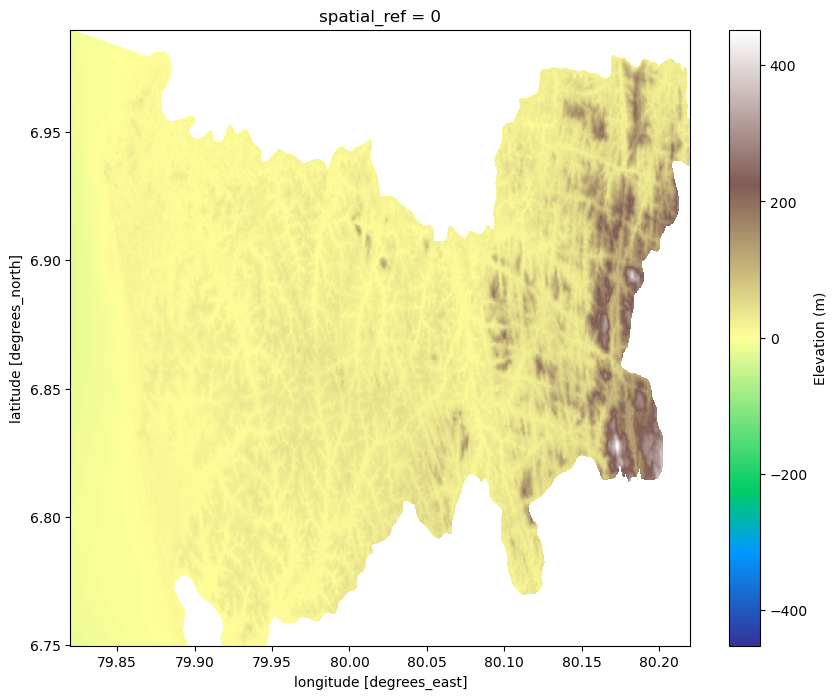

In [11]:
# Mask Elevation with District Boundary
elevation = data_loading.load_srtm_tiles(RAW_DIR / 'dem', bbox=(COLOMBO_BBOX['west'], COLOMBO_BBOX['south'], COLOMBO_BBOX['east'], COLOMBO_BBOX['north']))

# Apply Mask
elevation = raster_analysis.mask_raster_with_vector(elevation, district_mask)

print(f"Elevation data loaded and masked: {elevation.shape}")
elevation.plot(cmap='terrain', figsize=(10, 8), cbar_kwargs={'label': 'Elevation (m)'})

In [12]:
# Load CHIRPS 2025 rainfall data and clip to study area
print("Loading CHIRPS 2025 monthly rainfall data...")

chirps_file = RAW_DIR / 'chirps' / 'chirps-v2.0.2025.monthly.nc'

if chirps_file.exists():
    # Load full dataset
    ds = xr.open_dataset(chirps_file)
    
    # Get the precipitation variable and clip to BBOX first
    # Slice latitude (handle both ascending and descending cases)
    rainfall_cube = ds['precip'].sel(
        latitude=slice(COLOMBO_BBOX['south'], COLOMBO_BBOX['north']),
        longitude=slice(COLOMBO_BBOX['west'], COLOMBO_BBOX['east'])
    )
    if rainfall_cube.size == 0:
       rainfall_cube = ds['precip'].sel(
          latitude=slice(COLOMBO_BBOX['north'], COLOMBO_BBOX['south']),
          longitude=slice(COLOMBO_BBOX['west'], COLOMBO_BBOX['east'])
       )

    # Apply District Mask
    try:
        rainfall_cube = raster_analysis.mask_raster_with_vector(rainfall_cube, district_mask)
        print(f"Rainfall data loaded and masked: {rainfall_cube.shape}")
    except Exception as e:
        print(f"Warning: Masking failed ({e}), using rectangular clip")
    
else:
    print("CHIRPS file not found")

Loading CHIRPS 2025 monthly rainfall data...


In [13]:
# Load and Clip OSM Buildings
print("Loading OSM Buildings...")
osm_buildings_file = RAW_DIR / 'buildings' / 'osm_buildings.json'

if osm_buildings_file.exists():
    buildings = data_loading.load_osm_buildings(osm_buildings_file)
    
    # Clip to District (Masking requirement)
    # Check if district_mask is available (defined in earlier cell)
    if 'district_mask' in locals():
        try:
            print("Clipping buildings to district boundary...")
            buildings = vector_analysis.clip_vectors_to_boundary(buildings, district_mask)
        except Exception as e:
            print(f"Clipping failed: {e}")
    
    print(f"Loaded {len(buildings)} buildings")
else:
    print("OSM Buildings file not found. Please run Section 0.4.")

Loading OSM Buildings...
Clipping buildings to district boundary...
Loaded 231557 buildings


In [14]:
# Download Real Admin Boundaries (Level 9 - Wards) & Parse Manually
from shapely.geometry import LineString, Polygon, MultiPolygon
from shapely.ops import linemerge, unary_union
import warnings

print("Downloading Admin Level 9 Wards and parsing geometry...")

ds_path = RAW_DIR / 'admin' / 'colombo_wards.json'

def parse_overpass_relation_to_poly(element):
    """Convert an Overpass Relation element with geometry to a Shapely Polygon."""
    try:
        # Collect all way segments from members
        segments = []
        for member in element.get('members', []):
            if member['type'] == 'way' and 'geometry' in member:
                coords = [(pt['lon'], pt['lat']) for pt in member['geometry']]
                if len(coords) >= 2:
                    segments.append(LineString(coords))
        
        if not segments:
            return None
            
        # Merge segments into a single line (or set of lines)
        merged = linemerge(segments)
        
        # Convert to Polygon if closed
        if merged.is_closed and not merged.is_empty:
             return Polygon(merged)
        elif hasattr(merged, 'geoms'): # MultiLineString
             # Try to polygonize
             from shapely.ops import polygonize
             polys = list(polygonize(merged))
             if len(polys) == 1:
                 return polys[0]
             elif len(polys) > 1:
                 return MultiPolygon(polys)
        
        return None
    except Exception as e:
        # print(f"Parse error for relation {element.get('id')}: {e}")
        return None


if not ds_path.exists() or True: # Force check logic
    overpass_url = "https://overpass-api.de/api/interpreter"
    
    # Query for Admin Level 9 relations with full geometry
    ds_query = f"""
    [out:json][timeout:180];
    (
      relation["admin_level"="9"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
    );
    out geom;
    """
    
    try:
        if not ds_path.exists():
            print("  Querying Overpass API...")
            response = requests.post(overpass_url, data={'data': ds_query}, timeout=300)
            response.raise_for_status()
            raw_data = response.json()
        else:
            # If file exists but failed to read before, it might be the raw JSON
            # Let's try to read it as JSON and parse it
            print("  Reprocessing existing download reference...")
            with open(ds_path, 'r') as f:
                 raw_data = json.load(f)
            
        # Process elements to GeoDataFrame
        features = []
        elements = raw_data.get('elements', [])
        
        for el in elements:
            if el['type'] == 'relation':
                geom = parse_overpass_relation_to_poly(el)
                if geom:
                    tags = el.get('tags', {})
                    feat = tags.copy()
                    feat['geometry'] = geom
                    feat['id'] = el['id']
                    features.append(feat)
        
        if features:
            gdf = gpd.GeoDataFrame(features, crs="EPSG:4326")
            # Ensure unique IDs
            if 'ds_id' not in gdf.columns:
                gdf['ds_id'] = [f"W{i:02d}" for i in range(len(gdf))]
            if 'ds_name' not in gdf.columns:
                gdf['ds_name'] = gdf.get('name', 'Unknown')
            
            # Save as Clean GeoJSON
            gdf.to_file(ds_path, driver="GeoJSON")
            print(f"  Successfully parsed and saved {len(gdf)} Wards to {ds_path.name}")
            admin_boundaries = gdf
        else:
            print("  Warning: No valid geometries could be parsed from API response.")
            ds_path.unlink(missing_ok=True)
            
    except Exception as e:
        print(f"  Error processing admin data: {e}")
        if ds_path.exists():
            # If it's the raw file causing issues, remove it so we retry clean next time
            pass 

# Final Load Verification
if 'admin_boundaries' not in locals() and ds_path.exists():
    try:
        admin_boundaries = gpd.read_file(ds_path)
        print(f"Loaded {len(admin_boundaries)} admin divisions.")
        
        # Filter by District (Spatial Join)
        if 'district_mask' in locals():
             print("Filtering to district mask...")
             admin_boundaries = gpd.overlay(admin_boundaries, district_mask, how='intersection')
             print(f"Filtered: {len(admin_boundaries)} divisions remain.")
             
    except Exception as e:
        print(f"Final Load Failed: {e}")


  Querying Overpass API...
  Successfully parsed and saved 37 Wards to colombo_wards.json


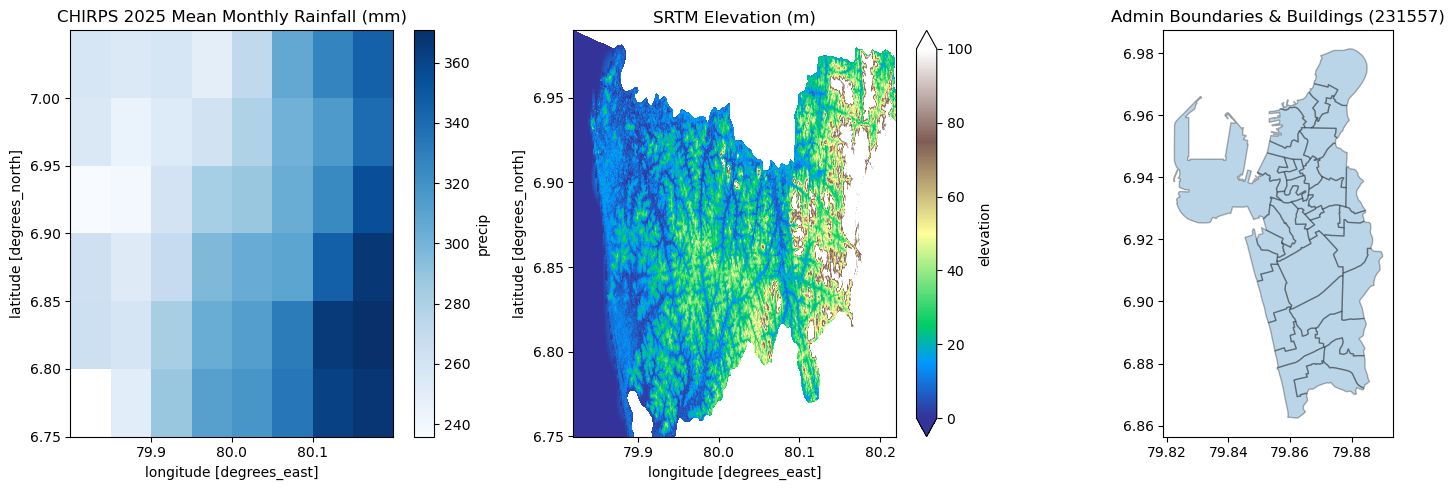

In [15]:
# Visualize the real data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Rainfall
rainfall_cube.mean(dim='time').plot(ax=axes[0], cmap='Blues')
axes[0].set_title('CHIRPS 2025 Mean Monthly Rainfall (mm)')

# Elevation
elevation.plot(ax=axes[1], cmap='terrain', vmin=0, vmax=100)
axes[1].set_title('SRTM Elevation (m)')

# Admin and buildings
admin_boundaries.plot(ax=axes[2], alpha=0.3, edgecolor='black')
if len(buildings) < 5000:
    buildings.plot(ax=axes[2], color='red', markersize=0.5, alpha=0.5)
axes[2].set_title(f'Admin Boundaries & Buildings ({len(buildings)})')

plt.tight_layout()
plt.show()

---

## 2. NumPy Array Operations

Array-based raster processing using real data.

In [16]:
# Get rainfall as numpy array
rainfall_np = rainfall_cube.values
print(f"Rainfall array shape: {rainfall_np.shape} (months, lat, lon)")

# Calculate max monthly rainfall for usage in operations
max_monthly_rainfall = rainfall_cube.max(dim='time')
print(f"Max monthly rainfall range: {float(max_monthly_rainfall.min()):.1f} - {float(max_monthly_rainfall.max()):.1f} mm")

Rainfall array shape: (12, 6, 8) (months, lat, lon)
Max monthly rainfall range: 524.1 - 714.0 mm


In [17]:
# Operation 1: Create high rainfall mask (>300mm/month threshold)
high_rainfall_mask = rainfall_np > 300
print(f"High rainfall events (>300mm/month): {high_rainfall_mask.sum()} grid-months")

High rainfall events (>300mm/month): 256 grid-months


Text(0.5, 1.0, 'Max Monthly Rainfall (Masked)')

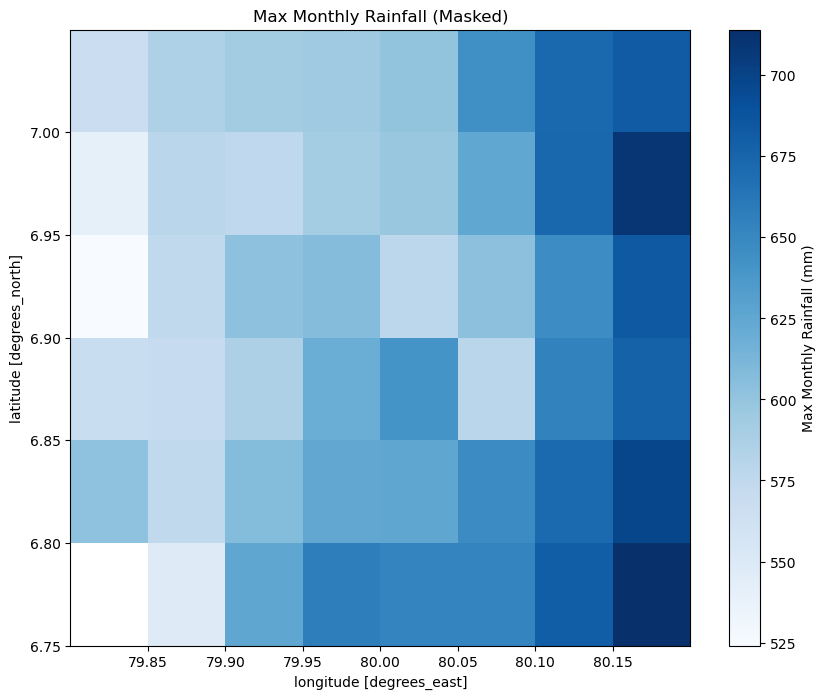

In [18]:
max_monthly_rainfall.plot(cmap='Blues', figsize=(10, 8), cbar_kwargs={'label': 'Max Monthly Rainfall (mm)'})
plt.title('Max Monthly Rainfall (Masked)')

In [19]:
# Operation 3: Calculate mean annual rainfall
mean_annual = np.nanmean(rainfall_np, axis=0) * 12  # Convert to annual
print(f"Estimated annual rainfall: {np.nanmean(mean_annual):.0f} mm/year")

Estimated annual rainfall: 3560 mm/year


In [20]:
# Operation 4: Normalize for vulnerability calculation
rainfall_norm = raster_analysis.normalize_array(max_monthly_rainfall, method='minmax')
elev_values = elevation.values
elev_values = np.nan_to_num(elev_values, nan=np.nanmean(elev_values))
elevation_norm = raster_analysis.normalize_array(elev_values, method='minmax')

print(f"Normalized rainfall range: {np.nanmin(rainfall_norm):.3f} - {np.nanmax(rainfall_norm):.3f}")
print(f"Normalized elevation range: {np.nanmin(elevation_norm):.3f} - {np.nanmax(elevation_norm):.3f}")

Normalized rainfall range: 0.000 - 1.000
Normalized elevation range: 0.000 - 1.000


---

## 3. PyTorch Tensor Operations

GPU-aware processing with performance comparison.

In [21]:
# Check GPU availability
tensor_operations.print_gpu_info()

Device Information
CUDA available: No
Apple MPS available: Yes (Apple Silicon GPU)
PyTorch version: 2.10.0


In [22]:
# Convert to tensor
rainfall_tensor = tensor_operations.numpy_to_tensor(max_monthly_rainfall, device='auto')
print(f"Tensor device: {rainfall_tensor.device}")
print(f"Tensor shape: {rainfall_tensor.shape}")

Tensor device: mps:0
Tensor shape: torch.Size([6, 8])


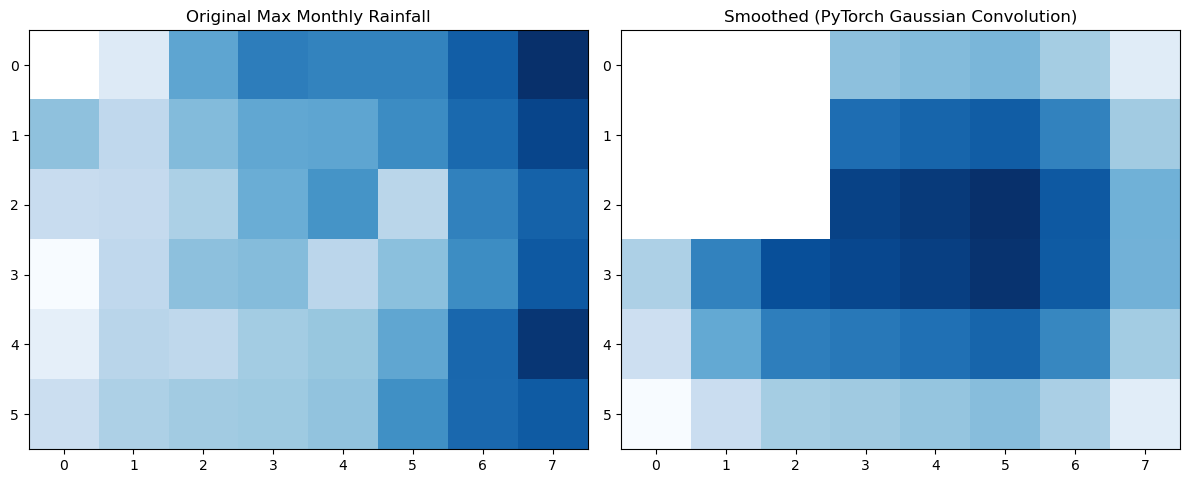

In [23]:
# Apply Gaussian convolution for spatial smoothing
smoothed_tensor = tensor_operations.apply_gaussian_convolution(
    rainfall_tensor, kernel_size=5, sigma=1.5
)

# Convert back to numpy for visualization
smoothed = tensor_operations.tensor_to_numpy(smoothed_tensor)

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(max_monthly_rainfall, cmap='Blues', origin='upper')
axes[0].set_title('Original Max Monthly Rainfall')
axes[1].imshow(smoothed, cmap='Blues', origin='upper')
axes[1].set_title('Smoothed (PyTorch Gaussian Convolution)')
plt.tight_layout()
plt.show()

In [24]:
# PERFORMANCE COMPARISON: NumPy vs PyTorch
print("Running performance comparison...")
print("(Measuring Gaussian convolution speed)\n")

perf_results = tensor_operations.compare_numpy_vs_torch(
    max_monthly_rainfall, kernel_size=5, sigma=1.5, num_iterations=10
)

print("=" * 55)
print("        PERFORMANCE COMPARISON RESULTS")
print("=" * 55)
print(f"Array size:        {max_monthly_rainfall.shape}")
print(f"Operation:         5x5 Gaussian Convolution")
print(f"Iterations:        10")
print("")
print(f"NumPy (scipy):     {perf_results['numpy_time']*1000:.2f} ms +/- {perf_results['numpy_std']*1000:.2f} ms")
print(f"PyTorch ({perf_results['device']:6s}):  {perf_results['torch_time']*1000:.2f} ms +/- {perf_results['torch_std']*1000:.2f} ms")
print("")
print(f"Speedup:           {perf_results['speedup']:.2f}x")
print("=" * 55)

Running performance comparison...
(Measuring Gaussian convolution speed)



TypeError: len() of unsized object

---

## 4. Vector Processing (GeoPandas/Shapely)

At least 3 vector operations as required.

In [ ]:
# OPERATION 1: Spatial Join - assign DS to each building
buildings_joined = vector_analysis.spatial_join_buildings_to_admin(
    buildings, admin_boundaries, admin_id_col='ds_id'
)

print("OPERATION 1: Spatial Join")
print(f"   Buildings with DS assignment: {len(buildings_joined)}")
print(buildings_joined[['building_id', 'ds_id']].head())

In [ ]:
# OPERATION 2: Building Density Calculation
admin_with_density = vector_analysis.calculate_building_density(
    buildings, admin_boundaries, admin_id_col='ds_id'
)

print("OPERATION 2: Building Density Calculation")
print(admin_with_density[['ds_name', 'building_count', 'building_density']])

In [ ]:
# OPERATION 3: Buffer analysis
from shapely.geometry import LineString

# Create sample roads
roads = gpd.GeoDataFrame({
    'road_id': ['R01', 'R02', 'R03'],
    'highway': ['primary', 'secondary', 'primary'],
    'geometry': [
        LineString([(79.82, 6.9), (80.1, 6.9)]),
        LineString([(79.9, 6.75), (79.9, 7.0)]),
        LineString([(79.85, 6.85), (80.0, 6.95)])
    ]
}, crs='EPSG:4326')

# Buffer analysis
road_buffers = vector_analysis.create_road_buffers(
    roads, buffer_distance=0.005, road_types=['primary', 'secondary']
)

print("OPERATION 3: Buffer Analysis")
print(f"   Created {len(road_buffers)} road buffers")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
admin_with_density.plot(ax=ax, column='building_density', cmap='Reds', alpha=0.5, legend=True)
road_buffers.plot(ax=ax, color='yellow', alpha=0.5)
roads.plot(ax=ax, color='black', linewidth=2)
if len(buildings) < 2000:
    buildings.plot(ax=ax, color='blue', markersize=0.5, alpha=0.3)
ax.set_title('Building Density & Road Infrastructure')
plt.show()

---

## 5. Xarray Data Cubes

Multi-temporal analysis with real CHIRPS 2025 data.

In [ ]:
# Show data cube structure
print("Rainfall Data Cube Structure:")
print(rainfall_cube)

In [ ]:
# Monthly spatial mean
monthly_spatial_mean = rainfall_cube.mean(dim=['latitude', 'longitude'])

plt.figure(figsize=(10, 4))
monthly_spatial_mean.plot(marker='o')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Rainfall (mm)')
plt.title('Monthly Rainfall Pattern - Colombo District (CHIRPS 2025)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Identify wettest and driest months
wettest_idx = int(monthly_spatial_mean.argmax())
driest_idx = int(monthly_spatial_mean.argmin())

print(f"Wettest month: {rainfall_cube.time.values[wettest_idx]} ({float(monthly_spatial_mean[wettest_idx]):.1f} mm)")
print(f"Driest month:  {rainfall_cube.time.values[driest_idx]} ({float(monthly_spatial_mean[driest_idx]):.1f} mm)")

---

## 6. Raster-Vector Integration

Bidirectional integration as required.

In [ ]:
# Save rasters for integration
import rasterio
from rasterio.transform import from_bounds

bounds = (COLOMBO_BBOX['west'], COLOMBO_BBOX['south'], 
          COLOMBO_BBOX['east'], COLOMBO_BBOX['north'])

# Save rainfall raster
h, w = max_monthly_rainfall.shape
rainfall_path = OUTPUT_DIR / 'max_rainfall.tif'
with rasterio.open(
    rainfall_path, 'w', driver='GTiff',
    height=h, width=w, count=1, dtype='float32',
    crs='EPSG:4326', transform=from_bounds(*bounds, w, h)
) as dst:
    dst.write(max_monthly_rainfall.astype('float32'), 1)
print(f"Saved: {rainfall_path}")

# Save elevation raster  
h2, w2 = elev_values.shape
elevation_path = OUTPUT_DIR / 'elevation.tif'
with rasterio.open(
    elevation_path, 'w', driver='GTiff',
    height=h2, width=w2, count=1, dtype='float32',
    crs='EPSG:4326', transform=from_bounds(*bounds, w2, h2)
) as dst:
    dst.write(elev_values.astype('float32'), 1)
print(f"Saved: {elevation_path}")

In [ ]:
# RASTER to VECTOR: Zonal Statistics
admin_with_rainfall = integration.extract_zonal_statistics(
    admin_boundaries, rainfall_path,
    stats=['mean', 'max'], prefix='rainfall_'
)

admin_with_elev = integration.extract_zonal_statistics(
    admin_with_rainfall, elevation_path,
    stats=['mean', 'min'], prefix='elevation_'
)

print("RASTER to VECTOR: Zonal Statistics")
print(admin_with_elev[['ds_name', 'rainfall_mean', 'elevation_mean']])

In [ ]:
# VECTOR to RASTER: Rasterize building density
density_raster = integration.rasterize_vector(
    admin_with_density,
    value_column='building_density',
    resolution=(-0.005, 0.005)
)

print("VECTOR to RASTER: Rasterized Building Density")
print(f"   Shape: {density_raster.shape}")

plt.figure(figsize=(8, 6))
density_raster.plot(cmap='Oranges')
plt.title('Rasterized Building Density')
plt.show()

### Calculate Vulnerability Index

In [ ]:
# Combine all factors for vulnerability
result = admin_with_density.merge(
    admin_with_elev[['ds_id', 'rainfall_mean', 'rainfall_max', 'elevation_mean', 'elevation_min']],
    on='ds_id'
)

# Normalize factors
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-10)

rainfall_norm_v = normalize(result['rainfall_mean'])
density_norm_v = normalize(result['building_density'])
elev_norm_v = normalize(result['elevation_mean'])

# Calculate vulnerability: V = 0.4*rainfall + 0.3*density + 0.3*(1-elevation)
result['vulnerability_score'] = (
    0.4 * rainfall_norm_v +
    0.3 * density_norm_v +
    0.3 * (1 - elev_norm_v)  # low elevation = high vulnerability
)

# Classify
result['vulnerability_class'] = pd.cut(
    result['vulnerability_score'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['Low', 'Moderate', 'High', 'Extreme']
)

print("VULNERABILITY ASSESSMENT RESULTS")
print("=" * 80)
print(result[['ds_name', 'rainfall_mean', 'building_density', 'elevation_mean', 'vulnerability_score', 'vulnerability_class']])
print("=" * 80)

---

## 7. Visualization

Final maps and outputs.

In [ ]:
# Add required columns for visualization
result['id'] = result['ds_id']

# Create interactive vulnerability map
vuln_map = visualization.create_vulnerability_map(
    result,
    value_column='vulnerability_score',
    title='Flood Vulnerability Score'
)

# Display
vuln_map

In [ ]:
# Save interactive map
vuln_map.save(OUTPUT_DIR / 'vulnerability_map.html')
print(f"Saved: {OUTPUT_DIR / 'vulnerability_map.html'}")

In [ ]:
# Create ranking chart
ranking_chart = visualization.create_vulnerability_ranking_chart(
    result,
    name_column='ds_name',
    value_column='vulnerability_score',
    top_n=10,
    title='Vulnerability Ranking - Colombo District'
)
ranking_chart.show()

In [ ]:
# Create static map for report
fig = visualization.create_static_map(
    result,
    value_column='vulnerability_score',
    title='Flood Vulnerability Assessment - Colombo District, Sri Lanka (CHIRPS 2025)',
    cmap='YlOrRd'
)

fig.savefig(OUTPUT_DIR / 'vulnerability_map.png', dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'vulnerability_map.png'}")

---

## Summary

This notebook demonstrated all required technical components using **real data**:

| Component | Implementation | Data Source |
|-----------|----------------|-------------|
| **NumPy Arrays** | Masking, normalization, statistics | CHIRPS rainfall |
| **PyTorch Tensors** | Gaussian convolution, performance comparison | Rainfall grid |
| **Vector Processing** | Spatial join, density, buffer (3+ ops) | OSM buildings |
| **Xarray Data Cubes** | Temporal slicing, aggregation | CHIRPS 2025 monthly |
| **Raster-Vector Integration** | Zonal stats (R-V), rasterization (V-R) | Both |

**Data Sources:**
- SRTM DEM from AWS Open Data
- CHIRPS 2025 monthly rainfall from UCSB
- Building footprints from OpenStreetMap

**Vulnerability Formula:**

$$V = 0.4 \times Rainfall_{norm} + 0.3 \times BuildingDensity_{norm} + 0.3 \times (1 - Elevation_{norm})$$